# Convolutional Neural Network - Char Classification
Using TensorFlow

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

%matplotlib notebook

# Creating CSV
import glob
import csv

# Display Graph
from IPython.display import clear_output, Image, display, HTML

# Helpers
from ocr.helpers import implt
from ocr.mlhelpers import TrainingPlot, DataSet

print("OpenCV: " + cv2.__version__)
print("Numpy: " + np.__version__)
print("TensorFlow: " + tf.__version__)

OpenCV: 3.1.0
Numpy: 1.12.1
TensorFlow: 1.1.0-rc2


In [2]:
def sofmaxLabels(lab, clas):
    """ Transform labels for sofmax classification """
    newLab = np.zeros((len(lab), clas), dtype=np.int8)
    for i in range(len(lab)):
        newLab[i][int(lab[i][0])] = 1
    return newLab

### Global Variables

In [3]:
LANG = 'en'

## Load Images and Lables in CSV

In [6]:
EN_CLAS = 53
CZ_CLAS = 83
CLAS = 53

if LANG == 'en':
    CLAS = EN_CLAS
elif LANG == 'cz':
    CLAS = CZ_CLAS

# dimension 64x64 = 4096
images = np.genfromtxt('data/charclas/' + LANG + '-data.csv', delimiter=',')
labels = np.genfromtxt('data/charclas/' + LANG + '-labels.csv', delimiter=',')
labels = np.reshape(labels, (len(labels), 1))

# Regularization of images
images[images < 40] = 0
images = images.astype(np.float32)
images = np.multiply(images, 1.0 / 255.0)

print("CSV data files loaded.")
print("Number of images: " + str(len(images)))

# Splitting into train and test data
div = int(0.80 * len(images))

# Transform labels for sofmax output
llabels = sofmaxLabels(labels, CLAS)

trainData = images[0:div]
evalData = images[div:]

trainLabels = llabels[0:div]
evalLabels = llabels[div:]

print("Training images: %g" % div)

CSV data files loaded.
Number of images: 2607
Training images: 2085


In [15]:
label_indices = [np.where(np.argmax(trainLabels, 1) == i)[0]
                 for i in range(CLAS)]
labels_len = [len(label_indices[d])
              for d in range(CLAS)]

su = 0
for i in labels_len:
    su += i*(i-1)/2
print("Max number of positive pairs", su)
print("Min data per label", min(labels_len))
print("Data per label", labels_len)

Max number of positive pairs 82631.0
Min data per label 4
Data per label [29, 9, 4, 9, 10, 12, 12, 9, 16, 10, 14, 11, 12, 8, 11, 8, 8, 6, 15, 11, 16, 10, 9, 6, 10, 9, 11, 162, 33, 63, 57, 127, 22, 17, 45, 110, 84, 74, 136, 38, 77, 141, 74, 24, 70, 75, 75, 58, 56, 11, 21, 88, 52]


# Create classifier

### Dataset

In [ ]:
class Dataset:
    """
    Store data and provide interface for batches training and testing
    Create positive and negative pairs with ratio 1:1
    Ratio of pairs per lavel depends on labels_equal

    Requires: data, labels (with one hot encoding), number of labels, (eqal)
    """
    def __init__(self, data, labels, n_labels, labels_equal=True, max_pairs=-1):
        self.n_labels = n_labels
        self.label_indices = [np.where(np.argmax(labels, 1) == i)[0]
                              for i in range(n_labels)]
        self.data = data
        self.epoch = 0
        self.labels_equal = labels_equal
        self.max_pairs = max_pairs
        self.pos_pairs = self.generatePosPairs()
        self.neg_pairs = self.generateNegPairs()
        self.length = len(self.pos_pairs)
        self.index = 0

    def generatePosPairs(self):
        """ Returns positive pairs created from data set """
        pairs = []
        labels_len = [len(self.label_indices[d])
                      for d in range(self.n_labels)]

        start_time = time.time() # DEBUG

        if self.labels_equal:
            # Number of pairs depends on smallest label dataset
            n = min(labels_len)

            lab = 0
            idx = 0
            pad = 1

            while (len(pairs) < self.max_pairs or self.max_pais == -1) and pad < n:
                pairs += [[self.data[self.label_indices[lab][idx]],
                           self.data[self.label_indices[lab][idx + pad]]]]

                lab = (lab + 1) % self.n_labels
                if lab == 0:
                    idx += 1
                    if (idx + pad) >= n:
                        idx = 0
                        pad += 1

        else:
            # Create maximum number of pairs
            if self.max_pairs == -1:
                for lab in range(self.n_labels):
                    n = labels_len[lab]
                    for i in range(n-1):
                        for ii in range(i+1, n):
                            pairs += [[self.data[self.label_indices[lab][i]],
                                        self.data[self.label_indices[lab][ii]]]]
            else:
                # Number of pairs depends on smallest label dataset
                n = min(labels_len)
                lab = 0
                idx = 0
                pad = 1
                while len(pairs) < self.max_pairs:
                    if labels_len[lab] > pad:
                        pairs += [[self.data[self.label_indices[lab][idx]],
                                   self.data[self.label_indices[lab][pad]]]]
                    lab = (lab + 1) % self.n_labels
                    if lab == 0:
                        idx += 1
                        if idx == pad:
                            pad += 1
                            idx = 0
                

        print("Positive pairs generated in", time.time() - start_time) # DEBUG
        return np.array(pairs)

    def generateNegPairs(self):
        """ Retruns random negative pairs same length as positive pairs """
        pairs = []
        chosen = []
        i = 0
        start_time = time.time() # DEBUG
        while len(pairs) < len(self.pos_pairs):
            ii = (i + random.randrange(1, self.n_labels)) % self.n_labels
            choice = [random.choice(self.label_indices[i]),
                      random.choice(self.label_indices[ii])]
            if choice not in chosen:
                chosen += [choice]
                pairs += [[self.data[choice[0]], self.data[choice[1]]]]
            i = (i + 1) % self.n_labels

        print("Negative pairs generated in", time.time() - start_time) # DEBUG
        return np.array(pairs)

    def get_epoch(self):
        """ Get current dataset epoch """
        return self.epoch

    def get_length(self):
        """ Get positive pairs length """
        return self.length

    def next_batch(self, batch_size):
        """
        Returns batch of images and labels of given length
        Requires: even batch size
        """
        start = self.index
        l_size = int(batch_size / 2)
        self.index += l_size

        if self.index > self.length:
            # Shuffle the data
            perm = np.arange(self.length)
            np.random.shuffle(perm)
            self.pos_pairs = self.pos_pairs[perm]
            self.neg_pairs = self.generateNegPairs()
            # Start next epoch
            start = 0
            self.epoch += 1
            self.index = l_size

        end = self.index
        return (np.append(self.pos_pairs[start:end],
                          self.neg_pairs[start:end], 0),
                np.append(np.ones((l_size, 1)),
                          np.zeros((l_size, 1)), 0))

In [5]:
# Prepare training dataset
trainSet = Dataset(trainData, trainLabels, CLAS, False, 5000)
testSet = Dataset(evalData, evalLabels, CLAS, False, 5000)

## KNN

In [6]:
with tf.name_scope("KNN") as scope:
    # tf Graph Input
    xtr = tf.placeholder("float", [None, 4096])
    xte = tf.placeholder("float", [4096])

    # Nearest Neighbor calculation using L1 Distance
    # Calculate L1 Distance
    distance = tf.reduce_sum(tf.abs(tf.add(xtr, tf.negative(xte))), reduction_indices=1)
    # Prediction: Get min distance index (Nearest neighbor)
    pred = tf.arg_min(distance, 0)

accuracy = 0.

# Initializing the variables
init = tf.global_variables_initializer()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)

    # loop over test data
    for i in range(len(evalData)):
        # Get nearest neighbor
        nn_index = sess.run(pred, feed_dict={xtr: trainData, xte: evalData[i, :]})
        # Calculate accuracy
        if np.argmax(trainLabels[nn_index]) == np.argmax(evalLabels[i]):
            accuracy += 1./len(evalData)
            
print("Accuracy:", accuracy)

Accuracy: 0.6704980842911906


## Convulation Neural Network

### Graph

In [7]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
# Layers for CNN
def conv2d(input_, W_shape, name):
    """
    name - layer name for variable scope W_shape - [height, width, input_layers, output_layers]
    """
    with tf.variable_scope(name):
        W_conv = tf.get_variable('W_conv', shape=W_shape,
                                 initializer=tf.contrib.layers.xavier_initializer())
        b_conv = tf.Variable(tf.constant(0.1, shape=[W_shape[3]]), name="b_conv")

        return tf.nn.relu(tf.nn.conv2d(input_,
                                       W_conv,
                                       strides=[1, 1, 1, 1],
                                       padding='SAME') + b_conv)

def max_pool_2x2(input_):
    """ Perform max pool with 2x2 kelner"""
    return tf.nn.max_pool(input_, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


def fc(input_, input_dim, output_dim, name):
    """ Fully connected layer with Sigmoid activation """
    with tf.variable_scope(name):
        W_fc = tf.get_variable('W_fc', shape=[input_dim, output_dim],
                        initializer=tf.contrib.layers.xavier_initializer())
        b_fc = tf.Variable(tf.constant(0.1, shape=[output_dim]), name="b_fc")

        return tf.nn.sigmoid(tf.matmul(input_, W_fc) + b_fc)

# Model creator
def convnet(image):
    """
    Input size: 784
    Image initial size: 28x28x1
    After 5_conv size:  7x7x256
    Output vector of 4096 values
    """
    x_image = tf.reshape(image, [-1, 28, 28, 1])
    conv_1 = conv2d(x_image, [10, 10, 1, 64], "1_conv")
    pool_2 = max_pool_2x2(conv_1)
    conv_3 = conv2d(pool_2, [7, 7, 64, 128], "3_conv")
    pool_4 = max_pool_2x2(conv_3)
    conv_5 = conv2d(pool_4, [4, 4, 128, 256], "5_conv")
    flat_6 = tf.reshape(conv_5, [-1, 7*7*256])
    full_7 = fc(flat_6, 7*7*256, 4096, "7_full")
    return full_7


X_train = mnist.train.images
y_train = mnist.train.labels
X_test = mnist.test.images
y_test = mnist.test.labels

tr_data = Dataset(X_train, y_train, 10, max_pairs=5000)
te_data = Dataset(X_test, y_test, 10, max_pairs=5000)


### MODEL
images_L = tf.placeholder(tf.float32,shape=([None,784]),name='images_L')
images_R = tf.placeholder(tf.float32,shape=([None,784]),name='images_R')
labels = tf.placeholder(tf.float32,shape=([None,1]), name='labels')

with tf.variable_scope("ConvSiameseNet") as scope:
    model_L = convnet(images_L)
    scope.reuse_variables()
    model_R = convnet(images_R)

# Combine two outputs by L1 distance
distance = tf.abs(tf.subtract(model_L, model_R))

# Final layer with sigmoid
W_out = tf.get_variable('W_out', shape=[4096, 1],
                        initializer=tf.contrib.layers.xavier_initializer())
b_out = tf.Variable(tf.constant(0.1, shape=[1]), name="b_out")

# Output - result of sigmoid - for future use
# Prediction - rounded sigmoid to 0 or 1
output = tf.nn.sigmoid(tf.matmul(distance, W_out) + b_out)
prediction = tf.reduce_sum(output)
tf.add_to_collection('activation', output)
tf.add_to_collection('activation_sum', prediction)

# Using cross entropy for sigmoid as loss
# @TODO add regularization
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels,
                                                              logits=output))

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = 0.0001).minimize(loss)

# Measuring accuracy of model
correct_prediction = tf.equal(prediction, labels)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Training

<IPython.core.display.Javascript object>


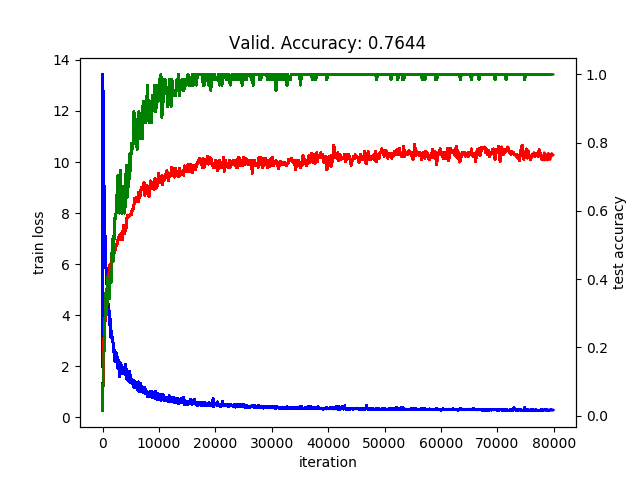

Accuracy 0.772031


In [8]:
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

# Set the logs writer to the folder and save graph for Tensorboard
# summary_writer = tf.summary.FileWriter('logs', sess.graph)

### SETTINGS  ###
TRAIN_STEPS = 4000
TEST_ITER = 150
COST_ITER = 50
SAVE_ITER = 400
BATCH_SIZE = 64

# Creat plot for live stats ploting
trainPlot = TrainingPlot(TRAIN_STEPS, TEST_ITER, COST_ITER)

for i in range(TRAIN_STEPS):
    trainBatch, labelBatch = trainSet.next_batch()
    tr_input, y = tr_data.next_batch(BATCH_SIZE)
    _, tmpCost, accTrain = sess.run([optimizer, loss, accuracy],
                                   feed_dict={images_L: tr_input[:,0],
                                              images_R: tr_input[:,1],
                                              labels: y})

    
    if i%COST_ITER == 0:
        # Plotting cost
        trainPlot.updateCost(tmpCost, i // COST_ITER)
    
    if i%TEST_ITER == 0:
        # Plotting accuracy
        te_pairs, te_y = te_data.next_batch(1000)
        accEval = accuracy.eval(feed_dict={images_L: te_pairs[:,0],
                                           images_R: te_pairs[:,1],
                                           labels: te_y})
        trainPlot.updateAcc(accEval, accTrain, i // TEST_ITER)
        
    if i%SAVE_ITER == 0:
        saver.save(sess, 'models/char-clas/' + LANG + '/CharClassifier-Siamese')

# Final Save
saver.save(sess, 'models/char-clas/' + LANG + '/CharClassifier-Siamese')

te_pairs, te_y = te_data.next_batch(2000)
accEval = accuracy.eval(feed_dict={images_L: te_pairs[:,0],
                                   images_R: te_pairs[:,1],
                                   labels: te_y})
print("Accuracy %g" % accEval)

sess.close()